## Topic 2: QSVM4EO - Land classification using quantum-enhanced support vector machines

This notebook will present examples of using quantum-enhanced support vector machines (QSVM) for classification tasks on multi-spectral Earth Observation (EO) data. The main topics covered are introduction to classical SVM, where quantum computation could be used in the SVM calculations, the intricacies of preparing and encoding the classical data into useful quantum states and training QSVMs on gate-based quantum software simulators. Finally, some results on comparing classical and quantum-enhanced SVM models will be presented.

QSVM code is adapted from Qiskit QSVM example: https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html

## Table of content

- Introduction
    - Use case
    - Theory
- QSVM Tutorial
- Exercise
- Conclusions

## Introduction

### Use case

What we're doing and why





### Theory

#### Support Vector Machines (SVM)

The SVM algorithm, in it’s original linear definition, is very similar to the linear classifier. But instead of trying to find any hyperplane separating the two data classes, it’s goal is to find the maximum margin between them with the assumption that they are linearly separable.

<div style="background-color: #ffffff; padding: 10px; text-align: center; width: fit-content;">
  <img src="images/SVM_margin.png" width="300"><br>
  <span style="font-style: italic; font-size: 14px;">(Source: https://commons.wikimedia.org/wiki/File:SVM_margin.png)</span>
</div>

##### Primal formulation

The primal formulation of SVM is as follows:

$$
\mathbf{w}^{\top} \mathbf{x}-b=0
$$

This could be reformulated as an optimization problem:

$$
\underset{\mathbf{w}, b}{\operatorname{argmin}} \frac{1}{2}\|\mathbf{w}\|^{2}
$$

with the following constraints:

$$
\begin{aligned}
\mathbf{w}^{\top} \mathbf{x}_{i}-b \geq 1 & \text { for } y_{i}=1 \\
\mathbf{w}^{\top} \mathbf{x}_{i}-b \leq-1 & \text { for } y_{i}=-1
\end{aligned}
$$

##### Dual Lagrangian formulation

In practice the Dual Lagrangian formulation is used:

$$
\mathcal{L}(\boldsymbol{\alpha})=\sum_{n=1}^{N} \alpha_{n}-\frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} y_{n} y_{m} \alpha_{n} \alpha_{m} \mathbf{x}_{n}^{\top} \mathbf{x}_{m}
$$

Maximize w.r.t. to α subject to:

$$
\begin{array}{r}
\alpha_n \geq 0 \text { for } n=1, \cdots, N \\
\qquad \sum_{n=1}^N \alpha_n y_n=0
\end{array}
$$

In this formulation the values of the Lagrangian multipliers $\alpha$ could be found with quadratic programming.

##### Kernel trick

The above formulations work for linearly separable data, but the real-world datasets are rarely linearly separable. In cases where the data points are intermixed, one could use a transformation function that is applied to the original datapoints $x_i$ that maps them to a new feature space. The hope is that in this new feature space the mapped datapoints $z_i$ are linearly separable. 

<div style="background-color: #ffffff; padding: 10px; text-align: center; width: fit-content;">
  <img src="images/SVM_kernel.png" width="600"><br>
  <span style="font-style: italic; font-size: 14px;">(Source: https://www.hackerearth.com/blog/developers/simple-tutorial-svm-parameter-tuning-python-r/
  )</span>
</div>

$$
\mathcal{L}(\boldsymbol{\alpha})=\sum_{n=1}^{N} \alpha_{n}-\frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} y_{n} y_{m} \alpha_{n} \alpha_{m} \mathbf{z}_{n}^{\top} \mathbf{z}_{m}
$$

subject to:

$$
\begin{array}{r}
\alpha_n \geq 0 \text { for } n=1, \cdots, N \\
\qquad \sum_{n=1}^N \alpha_n y_n=0
\end{array}
$$

Computing those new datapoints $z_i$ could be quite computationally expensive. To avoid it we could apply the kernel trick: instead of computing each new datapoint in the new feature space, what we need is some measure of distance between the datapoint vectors, for example their dot product, as seen in the equation above. So if we could compute it directly, by using the data in the original input space, we could speed up the computation and get access to kernels in infinite dimensions (for example the RBF kernel).

Some classical kernel functions:

$$
\begin{array}{l|l|l}
\hline \text { Name } & \text { Kernel } & \text { Hyperparameters } \\
\hline \text { Linear } & \mathbf{x}^{T} \mathbf{x}^{\prime} & - \\
\hline \text { Polynomial } & \left(\mathbf{x}^{T} \mathbf{x}^{\prime}+c\right)^{p} & p \in \mathbb{N}, c \in \mathbb{R} \\
\hline \text { Gaussian } & \mathrm{e}^{-\gamma\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}} & \gamma \in \mathbb{R}^{+} \\
\hline \text { Exponential } & \mathrm{e}^{-\gamma\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|} & \gamma \in \mathbb{R}^{+} \\
\hline \text { Sigmoid } & \tanh \left(\mathbf{x}^{T} \mathbf{x}^{\prime}+c\right) & c \in \mathbb{R} \\
\hline
\end{array}
$$

#### Quantum-enhanced Support Vector Machines (QSVM)

##### Quantum Dot product

 A single qubit state is mathematically defined as a unit vector in a two-dimensional complex vector space, i.e. a Hilbert Space. We could write the qubit state would be by using the vector notation - this is called a `ket` :

 $$
|\psi\rangle=\left[\begin{array}{l}
\alpha \\
\beta
\end{array}\right]
$$

As the coefficients (or amplitudes) $\alpha$ and $\beta$ are complex number, we can take their conjugates $\bar{\alpha}$ and $\bar{\beta}$:

$$
\begin{aligned}
\alpha & =x_0+i y_0 \\
\bar{\alpha} & =x_0-i y_0
\end{aligned}
$$

The conjugates helps us introduce the complement of a `ket`, called a `bra`, which is it’s conjugate transpose:

$$
\langle\psi|=|\psi\rangle^{\dagger}=\left[\begin{array}{ll}
\bar{\alpha} & \bar{\beta}
\end{array}\right]
$$

With this notation it becomes very easy to write dot products of quantum states in Hilbert space - for example the dot product of the state $\mid \psi\rangle$ with itself is defined as follows:

$$
\langle\psi \mid \psi\rangle=|\alpha|^2+|\beta|^2=1
$$

##### Quantum Kernels

Constructing quantum kernels is surprisingly simple. One approach is to first encode feature $x_n$ using rotation encoding routine $S(x_n)$. This produces a quantum state $\mid \phi\rangle$, parametrized on $x_n$. Then we reuse the same quantum circuit and this time encode feature $x_m$ using the inverse embedding $S(x_m)^†$, which produces a quantum state $\langle \phi\mid$, this time parametrized on $x_m$. This now forms a circuit, which is the dot product of the two encoded states, which defines a distance measure in Hilbert space. The last step is to perform projective measurement on the initial state, which produces the following quantum embedding kernel (QEK), dependent only on the two original classic data features $x_n$ and $x_m$:

$$
k\left(\boldsymbol{x_n}, \boldsymbol{x_m}\right)=\left|\left\langle\phi\left(\boldsymbol{x_m}\right) \mid \phi(\boldsymbol{x_n})\right\rangle\right|^{2}
$$

By encoding the data into quantum Hilbert Space in a clever way and without doing any additional operations we’re able to get a kernel producing a distance measure between datapoints.

<div style="background-color: #ffffff; padding: 10px; text-align: center; width: fit-content;">
  <img src="images/kernel_circuit.png" width="600"><br>
  <span style="font-style: italic; font-size: 14px;">(Source: https://pennylane.ai/qml/demos/tutorial_kernel_based_training)</span>
</div>

Now we could put everything together and define a quantum-enhanced version of Quantum Support Vector Machines (QSVM). In this particular version of QSVM all the classical computation steps in training a model and performing inference stay the same, with the exception of the computation of the kernel matrix, which is performed on a quantum computer or quantum software simulator. The dual Lagrangian is modified as follows:

$$
\mathcal{L}(\boldsymbol{\alpha})=\sum_{n=1}^N \alpha_n-\frac{1}{2} \sum_{n=1}^N \sum_{m=1}^N y_n y_m \alpha_n \alpha_m\left|\left\langle\phi\left(x_n\right) \mid \phi\left(x_m\right)\right\rangle\right|^2
$$

where $\phi(x_i)$ is a quantum feature map, encoding the classical data vector $x_i$ into quantum Hilbert space.

Comparison of the steps of a classical and quantum-enhanced SVM is shown below: 

<div style="background-color: #ffffff; padding: 10px; text-align: center; width: fit-content;">
  <img src="images/SVM_QSVM_workflows.png" width="600"><br>
  <span style="font-style: italic; font-size: 14px;"></span>
</div>

## QSVM Tutorial

### Imports and common functions

In [1]:
### Imports
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np

from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import FidelityStatevectorKernel

In [2]:
### Common functions

def read_csv(file_dir, selected_columns):
    df = pd.read_csv(file_dir)
    df_selected = df[selected_columns]
    X = df_selected.values
    Y = df['Label'].values
    return X,Y

### Dataset

In [ ]:
train_data = 'data/train_32.csv'
test_data = 'data/test_32.csv'

data_labels = ['B02', 'B03', 'B04', 'B08']
dim = len(data_labels)

train_features, train_labels = read_csv(train_data, data_labels)
test_features, test_labels = read_csv(test_data, data_labels)

### SMV classifiers

In [4]:
svm_classifier_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for svm_classifier_kernel in svm_classifier_kernels: 

    svc_classifier = SVC(kernel=svm_classifier_kernel)
    svc_classifier.fit(train_features, train_labels)

    train_score = svc_classifier.score(train_features, train_labels)
    test_score = svc_classifier.score(test_features, test_labels)

    print(f"Classical kernel {svm_classifier_kernel} classification test score: {test_score}")

Classical kernel linear classification test score: 0.5869140625
Classical kernel poly classification test score: 0.6494140625
Classical kernel rbf classification test score: 0.5400390625
Classical kernel sigmoid classification test score: 0.5732421875


### Quantum-enhanced SVM classifier

In [5]:
### Scale the data

scaler = StandardScaler().fit(train_features)
train_features_scaled = scaler.transform(train_features)
test_features_scaled = scaler.transform(test_features)

### Quantum data encoding with ZFeatureMap

In [6]:
# Quantum data encoding circuit repetitions
qec_repetitions = 1

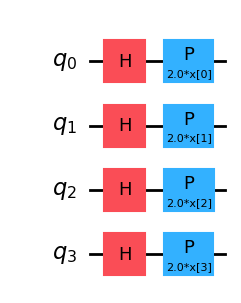

In [7]:
adhoc_feature_map = ZFeatureMap(feature_dimension=dim, reps=qec_repetitions)

adhoc_kernel = FidelityStatevectorKernel(feature_map=adhoc_feature_map)

adhoc_kernel.feature_map.decompose().draw("mpl")


In [8]:
%tb
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features_scaled)

No traceback available to show.


In [9]:
adhoc_svc = SVC(kernel="precomputed")

adhoc_svc.fit(adhoc_matrix_train, train_labels)

SVC(kernel='precomputed')

In [10]:
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features_scaled, y_vec=train_features_scaled)

In [11]:
adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f"Precomputed quantum kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed quantum kernel classification test score: 0.6455078125


### Quantum data encoding with ZZFeatureMap

In [15]:
### Available entanglement options: "linear", "circular", "sca", "full"
adhoc_feature_map = ZZFeatureMap(feature_dimension=dim, reps=qec_repetitions, entanglement="linear")
adhoc_kernel = FidelityStatevectorKernel(feature_map=adhoc_feature_map)
_ = adhoc_kernel.feature_map.decompose().draw("mpl")

In [16]:
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features_scaled)
adhoc_svc = SVC(kernel="precomputed")
_ = adhoc_svc.fit(adhoc_matrix_train, train_labels)

In [17]:
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features_scaled, y_vec=train_features_scaled)
adhoc_score_precomputed_kernel = adhoc_svc.score(adhoc_matrix_test, test_labels)
print(f"Precomputed quantum kernel classification test score: {adhoc_score_precomputed_kernel}")

Precomputed quantum kernel classification test score: 0.52734375


## Exercises

1. For a given quantum feature map, increase the number of repetitions of a quantum encoding layer  (parameter `qec_repetitions`). Do you observe any change in test accuracy?
2. Use all eight features from the dataset and repeat the experiments above with the classical and quantum-enhanced SVMs. Is there a change in the accuracy?

### Exercise 1

In [ ]:
# Quantum data encoding circuit repetitions
qec_repetitions = #YOUR CHOICE HERE

In [ ]:
# YOUR CODE HERE

### Exercise 2

In [ ]:
### Data loading

data_labels = ['B02', 'B03', 'B04', 'B08', 'NDVI', 'EVI', 'SAVI', 'NDWI']
dim = len(data_labels)

8

In [ ]:
### Classical SVM

# YOUR CODE HERE

In [ ]:
### Quantum-enhanced SVM

# YOU CODE HERE

## Conclusions

Discuss real-world results and experience.

## References
- http://work.caltech.edu/slides/slides14.pdf
- https://arxiv.org/abs/1803.07128
- https://arxiv.org/abs/2101.11020
- https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html
- https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZFeatureMap
- https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap
- https://pennylane.ai/qml/demos/tutorial_kernel_based_training

## Acknowledgements

We extend our gratitude to the Irish Centre for High-End Computing (ICHEC) and University of Galway for providing computing and for all-encompassing invaluable support. This project was funded by the EuroHPC JU under grant agreement No 951732 and Ireland.

<div>
  <img src="../logos/ICHEC.png" width="250" style="display: inline-block; margin-right: 30px;">
  <img src="../logos/UoG_.png" width="235" style="display: inline-block; margin-right: 30px;">
  <img src="../logos/EuroCC-Ireland.png" width="80" style="display: inline-block; margin-right: 30px;">
  <img src="../logos/EU-flag-Horizon-Europe.jpg" width="145" style="display: inline-block;">
</div>